In [66]:
import os
import itertools
import random

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler

import numpy as np
from scipy.stats import *
import pandas as pd
import seaborn as sns
import pyro as pyro

In [9]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':14})
rc('text', usetex=True)
plt.rc('axes', prop_cycle=(cycler('color', ['red', 'gray', 'black'])))#, 'blue', 'green'])))

# Gumbel distribution
$Y_i$ is the time-to-event for individual i, and we consider that $log(Y_i)$ follows a Gumbell distribution with the form:

$$ E(log Y_i|\mu, \beta, \delta, \alpha) = \mu + x'_i\beta +z'_i\delta $$
$$ Var(log Y_i|\mu, \beta, \delta, \alpha) = \frac{\pi}{6\alpha^2}$$

We have that 
- $\mu$: average scale for time-to-time event (intercept)
- $\beta$: SNP effect
- $\delta$: covariate effect
- $\alpha$: shape parameter of the distribution
- $x, z$: vectors of markers and covariates

_I dont know the difference between x, z and x', z'._

The Gumbel distribution looks like this for scale parameter 0 and shape parameter 0.1

In [68]:
mu, beta = 0, 0.1 # location and scale
s = np.random.gumbel(mu, beta, 1000)

In [54]:
def gumbel_distribution(x,b,a):
    return np.exp(-(x-b)/a)*np.exp(-np.exp(-(x-b)/a))/a

''

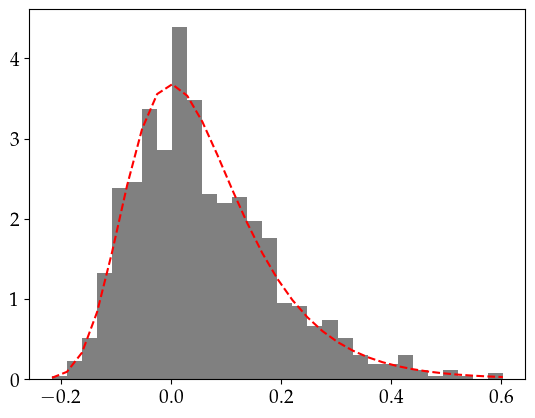

In [57]:
b = 0
a = 0.1
count, bins, ignored = plt.hist(s, 30, density=True, color = 'gray')
plt.plot(bins, gumbel_distribution(bins, 0,0.1), '--')
;

In [37]:
def scale_parameter(mu, beta, delta, markers, cov, shape_par):
    return np.exp(mu + np.dot(markers, beta) + np.dot(cov, delta) +(np.euler_gamma/shape_par))

We want to simulate a sample of one individual, with 100 markers and 10 covariates, where the effects are drawn from a normal distribution and the variables from a binomial distribution with probability 0.5. The shape parameter $\alpha$ is initialize to 0.1 and the average of the population is 10. 

In [39]:
size = 100
mu = 10
markers = np.random.binomial(2, 0.5, size)
cov = np.random.binomial(1, 0.5, size)
beta = np.random.normal(size=size)
delta=np.random.normal(size=size)
shape_par = 0.1

scale_par = scale_parameter(mu, beta, delta, markers, cov, shape_par)

In [64]:
shape_par, scale_par

(0.1, 206675.57146462216)

''

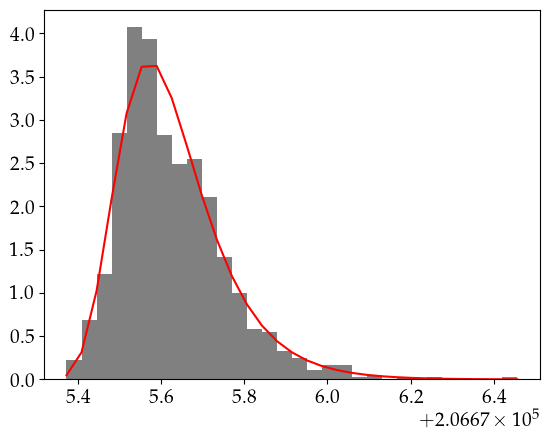

In [65]:
s = np.random.gumbel(scale_par, shape_par, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, color = 'gray')
plt.plot(bins, gumbel_distribution(bins, scale_par, shape_par))
;

# Algorithm 1
Serial algorithm for BayesW sampling from the posterior distribution $p(\mu, \alpha, \delta, \gamma, \beta, \pi, \sigma_G^2|D)$ .Initialisation and prior speciﬁcation.

__Data__: 
- matrix $x$ of standardised genotypes
- matrix with covariate data $z$, 
- vector of last time without an event $y$
- vector of failure indicators $d$
- prior hyperparameters , $p_L$:
    - $\alpha_0, \kappa_0$: parameters of the prior distribution of $\alpha$, gamma distribution
    $$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$
    - $\alpha_{\sigma}, \beta_{\sigma}$: parameters of the $\sigma_G^2$
    - $\sigma^2_{\mu}$: variance parameter of the prior distribution of $\mu$ 
    - $\sigma^2_{\delta}$: variance parameter of the prior distribution of $\delta$
- iterations $I$
- $V_0 , V_1 and V_2$ denote the partial sums of the exponentiated residuals
(deﬁned in Derivations for the sparse calculations)
- K is the Euler-Mascheroni constant.

__Initial values__: Initially, we exclude all the variables from the model.
- $y_j =0 \forall j \in {1,...,M}$. 
- $\beta_j =0 \forall j$ 
- $\sigma_q = 0 \forall q$ 
- $\alpha$: suitably transformed variance of the log sample. 
- $\mu$: mean of the log sample. 
- $\sigma_G^2$: the variance of the log sample divided by the total number of markers M.

__Parameters for prior distributions__: We set priors weakly informative. Otherwise, if
available, prior information could be used. 
- $\alpha$: $\alpha_0 = 0.01, \kappa_0 = 0.01$
- $\sigma^2_G$: $\alpha_{\sigma}=1$ and $\beta_{\sigma} = 0.0001$.
- $\mu$: $\sigma^2_{\mu} = 100$ 
- $\delta_q$:$\sigma^2_{\delta} = 100$
- $\pi$ and $p_L$: vector of ones

## Prior distributions
 prior hyperparameters , $p_L$:
    - $\alpha_0, \kappa_0$: parameters of the prior distribution of $\alpha$, gamma distribution
    $$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$
    - $\alpha_{\sigma}, \beta_{\sigma}$: parameters of the $\sigma_G^2$
    - $\sigma^2_{\mu}$: variance parameter of the prior distribution of $\mu$ 
    - $\sigma^2_{\delta}$: variance parameter of the prior distribution of $\delta$

Prior distribution of $\alpha$: gamma distribution with parameters $\alpha_0, \kappa_0$.

$$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$

Prior for $\beta_j$ follow a normal distribution with variance parameter $\sigma^2_G$

$$p(\beta_j|\sigma^2_G, y_j=k) \propto \left(\frac{1}{C_k\sigma_G^2}\right)^2 \exp(-\frac{1}{2C_k\sigma_G^2}\beta_j^2)$$

Prior of $\sigma^2_G$ follow a inverse gamma distribution with parameters $\alpha_{\sigma}, \beta_{\sigma}$

$$p(\sigma^2_G)\propto \left(\frac{1}{\sigma^2_G}\right)^{\alpha_{\sigma} +1}\exp\left(-\frac{\beta_{\sigma}}{\alpha_{\sigma}}\right)$$ 

Prior of $\delta_q$ (effect of the covariate q) is a normal with variance $\sigma^2_{\delta}$:

$$p(\delta_q)= \exp\left(-\frac{1}{2\sigma^2_{\delta}}\delta_q^2\right)$$

Prior of $\mu$ is a normal distribution with variance $\sigma^2_{\mu}$

$$p(\mu)= \exp\left(-\frac{1}{2\sigma^2_{\mu}}\mu^2\right)$$

The prior for $y_j$ is a multinomial distribution

$$p(y_j|\pi) = \pi_0^{I(y_j=0)}\cdot...\cdot \pi_L^{I(y_j=L)}$$

The prior probabilities of belonging to each of the mixture distributions k are stored in L+1 dimensional vector $\bf\pi$ with the prior for $\bf\pi$ a Dirichlet distribution

$$ p(\pi) = Dirichlet(p_L)$$

where $I(\cdot)$ is the indicator function and $p_L$ is the L+1 dimensional vector with prior values. 


